In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# from torchsummary import summary

import qiskit
from qiskit.visualization import *
from qiskit.circuit.random import random_circuit

from itertools import combinations

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)
print('cuda index:', torch.cuda.current_device())
print('GPU 이름:', torch.cuda.get_device_name())

Using PyTorch version: 1.10.1+cu113  Device: cuda
cuda index: 0
GPU 이름: NVIDIA GeForce RTX 3090


In [3]:
BATCH_SIZE = 10
EPOCHS = 10     # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
seed = 47
np.random.seed(seed)        # Seed for NumPy random number generator
torch.manual_seed(seed)     # Seed for TensorFlow random number generator

In [4]:
train_dataset = datasets.MNIST(root = "./data",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())

train_dataset.data    = train_dataset.data[:n_train]
train_dataset.targets = train_dataset.targets[:n_train]

test_dataset = datasets.MNIST(root = "./data",
                              train = False,
                              transform = transforms.ToTensor())

test_dataset.data    = test_dataset.data[:n_test]
test_dataset.targets = test_dataset.targets[:n_test]

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

In [5]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([10, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([10]) type: torch.LongTensor


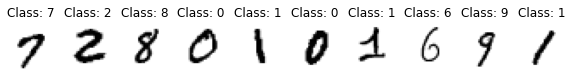

In [6]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

In [7]:
class QuanvCircuit:
    """ 
    This class defines filter circuit of Quanvolution layer
    """
    
    def __init__(self, kernel_size, backend, shots, threshold):
        # --- Circuit definition start ---
        self.n_qubits = kernel_size ** 2
        self._circuit = qiskit.QuantumCircuit(self.n_qubits)
        self.theta = [qiskit.circuit.Parameter('theta{}'.format(i)) for i in range(self.n_qubits)]

        for i in range(self.n_qubits):
            self._circuit.rx(self.theta[i], i)
        
        self._circuit.barrier()
        self._circuit += random_circuit(self.n_qubits, 2)
        self._circuit.measure_all()
        # ---- Circuit definition end ----

        self.backend   = backend
        self.shots     = shots
        self.threshold = threshold

    def run(self, data):
        # data shape: tensor (1, 5, 5)
        # val > self.threshold  : |1> - rx(pi)
        # val <= self.threshold : |0> - rx(0)

        # reshape input data
        # [1, kernel_size, kernel_size] -> [1, self.n_qubits]
        data = torch.reshape(data, (1, self.n_qubits))

        # encoding data to parameters
        thetas = []
        for dat in data:
            theta = []
            for val in dat:
                if val > self.threshold:
                    theta.append(np.pi)
                else:
                    theta.append(0)
            thetas.append(theta)
        
        param_dict = dict()
        for theta in thetas:
            for i in range(self.n_qubits):
                param_dict[self.theta[i]] = theta[i]
        param_binds = [param_dict]

        # execute random quantum circuit
        job = qiskit.execute(self._circuit, 
                             self.backend, 
                             shots = self.shots, 
                             parameter_binds = param_binds)
        result = job.result().get_counts(self._circuit)

        # decoding the result
        counts = 0
        for key, val in result.items():
            cnt = sum([int(char) for char in key])
            counts += cnt * val

        # Compute probabilities for each state
        probabilities = counts / (self.shots * self.n_qubits)
        # probabilities = counts / self.shots
        
        return probabilities

torch.Size([2, 2])
0.655


c:\program files\python38\lib\site-packages\sympy\core\expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


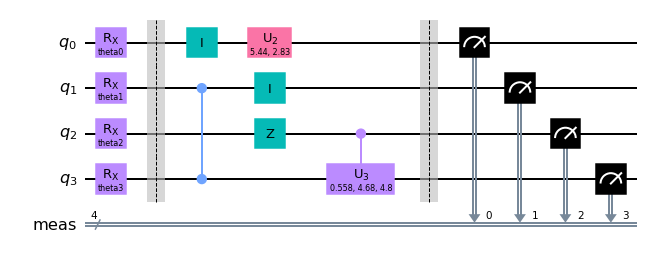

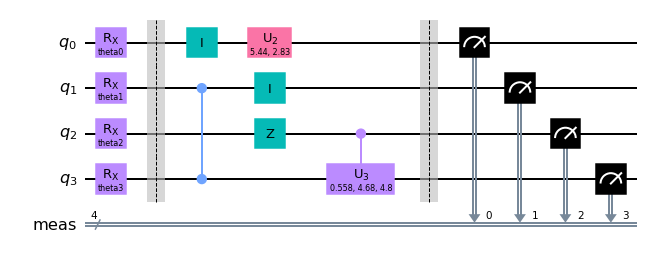

In [9]:
# backend = qiskit.Aer.get_backend('qasm_simulator')
backend = qiskit.providers.aer.QasmSimulator(method = "statevector")
filter_size = 2
circ = QuanvCircuit(filter_size, backend, 100, 127)
data = torch.tensor([[0, 200], [100, 255]])
# data = torch.tensor([[0, 200, 128, 192,168], [100, 255,53,47,29],[100, 255,53,47,29],[0, 200, 128, 192,168],[0, 200, 128, 192,168]])

print(data.size())
print(circ.run(data))

circ._circuit.draw(output='mpl')

In [11]:
class QuanvFunction(Function):
    """ Quanv function definition """
    
    @staticmethod
    def forward(ctx, inputs, in_channels, out_channels, kernel_size, quantum_circuits, shift):
        """ Forward pass computation """
        # input  shape : (-1, 1, 28, 28)
        # otuput shape : (-1, 6, 24, 24)
        ctx.in_channels      = in_channels
        ctx.out_channels     = out_channels
        ctx.kernel_size      = kernel_size
        ctx.quantum_circuits = quantum_circuits
        ctx.shift            = shift

        _, _, len_x, len_y = inputs.size()
        len_x = len_x - kernel_size + 1
        len_y = len_y - kernel_size + 1
        
        outputs = torch.zeros((len(inputs), len(quantum_circuits), len_x, len_y)).to(DEVICE)
        for i in range(len(inputs)):
            input = inputs[i]
            for c in range(len(quantum_circuits)):
                circuit = quantum_circuits[c]
                for h in range(len_y):
                    for w in range(len_x):
                        data = input[0, h:h+kernel_size, w:w+kernel_size]
                        outputs[i, c, h, w] = circuit.run(data)
        
        ctx.save_for_backward(inputs, outputs)
        return outputs

        
    @staticmethod
    def backward(ctx, grad_output): 
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None


class Quanv(nn.Module):
    """ Quanvolution(Quantum convolution) layer definition """
    
    def __init__(self, in_channels, out_channels, kernel_size, 
                 backend=qiskit.providers.aer.QasmSimulator(method="statevector"), 
                 shots=100, shift=np.pi/2):
        super(Quanv, self).__init__()
        self.quantum_circuits = [QuanvCircuit(kernel_size=kernel_size, 
                                              backend=backend, shots=shots, threshold=127) 
                                 for i in range(out_channels)]
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.kernel_size  = kernel_size
        self.shift        = shift
        
    def forward(self, inputs):
        return QuanvFunction.apply(inputs, self.in_channels, self.out_channels, self.kernel_size,
                                   self.quantum_circuits, self.shift)

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.quanv = Quanv(in_channels=1, out_channels=1, kernel_size = 3) # <- Quanv!!!!
        self.conv = nn.Conv2d(1, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.quanv(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        # x = x.view(-1, 256)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x)

In [13]:
model = Net().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
loss_list = []

model.train().to(DEVICE)
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.to(DEVICE)
        optimizer.zero_grad()

        # Forward pass
        output = model(data).to(DEVICE)

        # Calculating loss
        loss = loss_func(output, target).to(DEVICE)
        
        # Backward pass
        loss.backward()
        
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

batch0
channel0
batch1
channel0
batch2
channel0
batch3
channel0
batch4
channel0
batch5
channel0
batch6
channel0
batch7
channel0
batch8
channel0
batch9
channel0


C:\Users\A26A~1\AppData\Local\Temp/ipykernel_684/1153906363.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


batch0
channel0
batch1
channel0
batch2
channel0
batch3
channel0
batch4
channel0
batch5
channel0
batch6
channel0
batch7
channel0
batch8
channel0
batch9
channel0
batch0
channel0
batch1
channel0
batch2
channel0
batch3
channel0
batch4
channel0
batch5
channel0
batch6
channel0
batch7
channel0
batch8
channel0
batch9
channel0
batch0
channel0
batch1
channel0
batch2
channel0
batch3
channel0
batch4
channel0
batch5
channel0
batch6
channel0
batch7
channel0
batch8
channel0
batch9
channel0
batch0
channel0
batch1
channel0
batch2
channel0
batch3
channel0
batch4
channel0
batch5
channel0
batch6
channel0
batch7
channel0
batch8
channel0
batch9
channel0
Training [5%]	Loss: 2.3026
batch0
channel0
batch1
channel0
batch2
channel0
batch3
channel0
batch4
channel0
batch5
channel0
batch6
channel0
batch7
channel0
batch8
channel0
batch9
channel0
batch0
channel0
batch1
channel0
batch2
channel0
batch3
channel0
batch4
channel0
batch5
channel0
batch6
channel0
batch7
channel0
batch8
channel0
batch9
channel0
batch0
channe

In [15]:
model.eval()
with torch.no_grad():
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.cuda()
        target = target.cuda()
        output = model(data).cuda()
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss = loss_func(output, target)
        total_loss.append(loss.item())
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100 / BATCH_SIZE)
        )

batch0
channel0
batch1
channel0
batch2
channel0
batch3
channel0
batch4
channel0
batch5
channel0
batch6
channel0
batch7
channel0
batch8
channel0
batch9
channel0


C:\Users\A26A~1\AppData\Local\Temp/ipykernel_684/1153906363.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


batch0
channel0
batch1
channel0
batch2
channel0
batch3
channel0
batch4
channel0
batch5
channel0
batch6
channel0
batch7
channel0
batch8
channel0
batch9
channel0
batch0
channel0
batch1
channel0
batch2
channel0
batch3
channel0
batch4
channel0
batch5
channel0
batch6
channel0
batch7
channel0
batch8
channel0
batch9
channel0
Performance on test data:
	Loss: 2.2934
	Accuracy: 13.3%
